# Exercise 6 - Pixel classification and object segmentation
In the first part of this exercise, we will use pixel classification to label pixels in an image. In the second part, pixel classification will be combined with BLOB analysis to segment the spleen from a computed tomography (CT) scan.

In [3]:
from skimage import io, color
from skimage.morphology import binary_closing, binary_opening
from skimage.morphology import disk
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure
from skimage.color import label2rgb
import pydicom as dicom
from scipy.stats import norm
from scipy.spatial import distance


def show_comparison(original, modified, modified_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap="gray", vmin=-200, vmax=500)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(modified)
    ax2.set_title(modified_name)
    ax2.axis('off')
    io.show()

### Exericse 1 
Let us start by examining one of the CT scan slices from the training set. You can read the first slice like this coe below. 

You should visualise the slice, so the organs of interest have a suitable brigthness and contrast. One way is to manipulate the minimum and maximum values proviede to imshow.

Exercise 1: The spleen typically has HU units in the range of 0 to 150. Try to make a good visualization of the CT scan and spleen using (replace the question marks with values):

(512, 512)
int16


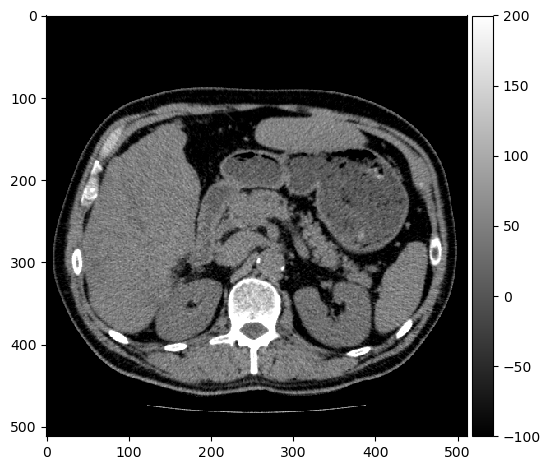

In [4]:
in_dir = "data/"
ct = dicom.read_file(in_dir + 'Training.dcm')
img = ct.pixel_array
print(img.shape)
print(img.dtype)

io.imshow(img, vmin=-100, vmax=200, cmap='gray')
io.show()

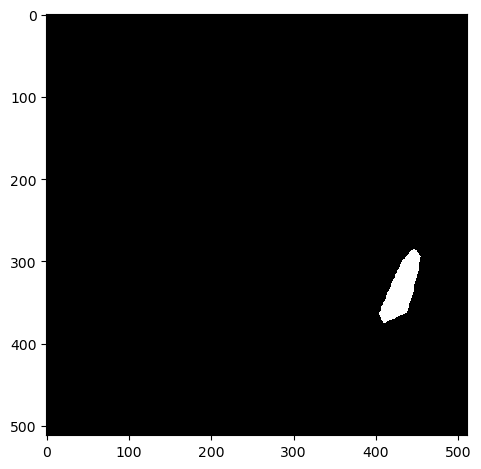

In [8]:
spleen_roi = io.imread(in_dir + 'SpleenROI.png')
# convert to boolean image
spleen_mask = spleen_roi > 0
spleen_values = img[spleen_mask]
#showing just the spleen with the mask 
io.imshow(spleen_mask)
io.show()

### Exercise 2 
Compute the average and standard deviation of the Hounsfield units found in the spleen in the training image. Do they correspond to the values found in the above figure?

In [17]:
mu_spleen = np.mean(spleen_values)
std_spleen = np.std(spleen_values)
print("Averae value for the spleen:",mu_spleen)
print("Standard deviation for the spleen:", std_spleen)

Averae value for the spleen: 49.48026905829597
Standard deviation for the spleen: 14.9970794143059


### Exercise 3 
Plot a histogram of the pixel values of the spleen. Does it look like they are Gaussian distributed?

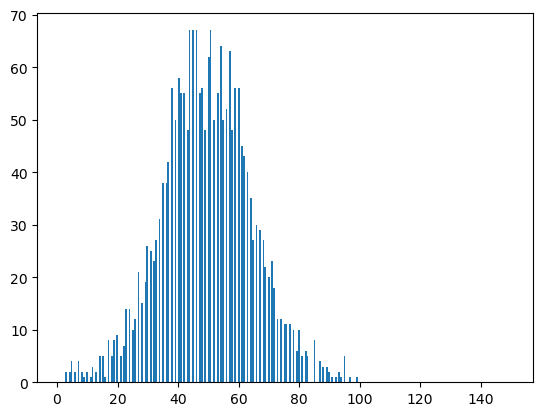

In [15]:
plt.hist(spleen_values, bins=256, range=(1, 150))
io.show()
#Yes it looks like a gaussian distribution

### Exercise 4 
Plot histograms and their fitted Gaussians of several of the tissues types. Do they all look like they are Gaussian distributed?

C:\Users\olive\AppData\Local\Temp\ipykernel_27120\1572005626.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([spleen_values, kidney_values, fat_values, bone_values, background_values, liver_values])


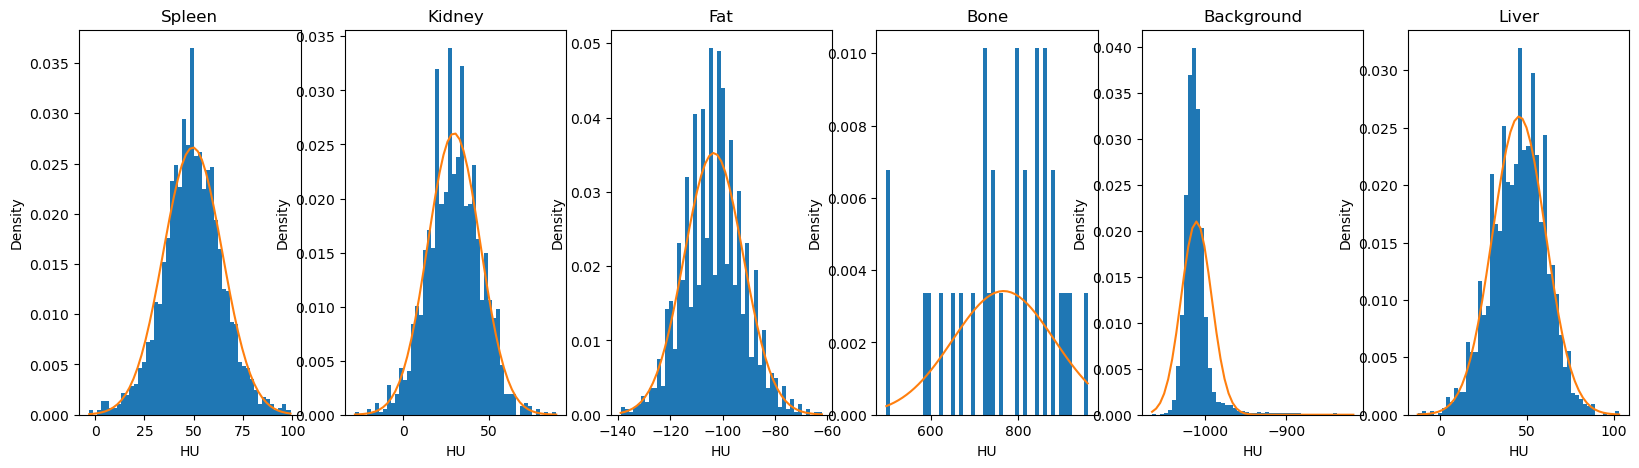

In [24]:
# Exercise 4 
# read ROIs 
kidney_roi = io.imread(in_dir + 'KidneyROI.png')
fat_roi = io.imread(in_dir + 'FatROI.png')
bone_roi = io.imread(in_dir + 'BoneROI.png')
background_roi = io.imread(in_dir + 'BackgroundROI.png')
liver_roi = io.imread(in_dir + "LiverROI.png")

# get values
kidney_mask, fat_mask, bone_mask, background_mask, liver_mask = kidney_roi > 0, fat_roi > 0, bone_roi > 0, background_roi > 0, liver_roi > 0 
kidney_values, fat_values, bone_values, background_values, liver_values = img[kidney_mask], img[fat_mask], img[bone_mask], img[background_mask], img[liver_mask]

# compute mean and std 
mu_kidney, mu_fat, mu_bone, mu_background, mu_liver = np.mean(kidney_values), np.mean(fat_values), np.mean(bone_values), np.mean(background_values), np.mean(liver_values)
std_kidney, std_fat, std_bone, std_background, std_liver = np.std(kidney_values), np.std(fat_values), np.std(bone_values), np.std(background_values), np.std(liver_values)

# gather in array for easy plotting 
means = np.array([mu_spleen, mu_kidney, mu_fat, mu_bone, mu_background, mu_liver])
stds = np.array([std_spleen, std_kidney, std_fat, std_bone, std_background, std_liver])
titles = np.array(["Spleen", "Kidney", "Fat", "Bone", "Background", "Liver"])
values = np.array([spleen_values, kidney_values, fat_values, bone_values, background_values, liver_values])
ns, bins, patches = [], [], []
fig, ax = plt.subplots(1, 6, figsize = (20, 5))
for i in range(6): 
    n, bin, patch = ax[i].hist(values[i].ravel(), bins = 50, density=True)
    ns.append(n), bins.append(bin), patches.append(patch)
    ax[i].plot(bin, norm.pdf(bin, means[i], stds[i]))
    ax[i].set_xlabel("HU")
    ax[i].set_ylabel("Density")
    ax[i].set_title(titles[i])
plt.show()

### Exercise 5 
Plot the fitted Gaussians of bone, fat, kidneys, liver and spleen. What classes are easy to seperate and which classes are hard to seperate?

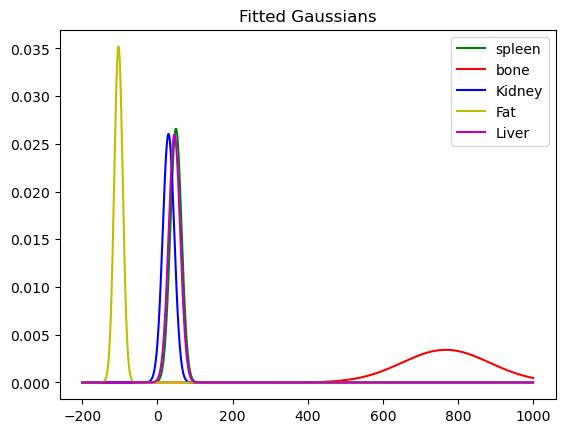

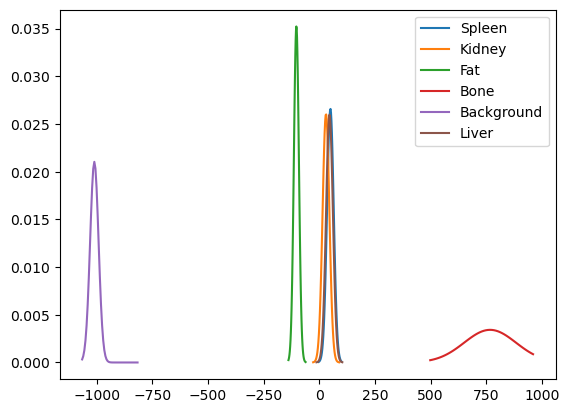

In [33]:
# Hounsfield unit limits of the plot
min_hu = -200
max_hu = 1000
hu_range = np.arange(min_hu, max_hu, 1.0)
pdf_spleen = norm.pdf(hu_range, mu_spleen, std_spleen)
pdf_bone = norm.pdf(hu_range, mu_bone, std_bone)
pdf_kidney = norm.pdf(hu_range, mu_kidney, std_kidney)
pdf_fat = norm.pdf(hu_range, mu_fat, std_fat)
pdf_liver = norm.pdf(hu_range, mu_liver, std_liver)

plt.plot(hu_range, pdf_spleen, 'g', label="spleen")
plt.plot(hu_range, pdf_bone, 'r', label="bone")
plt.plot(hu_range, pdf_kidney, 'b', label="Kidney")
plt.plot(hu_range, pdf_fat, 'y', label="Fat")
plt.plot(hu_range, pdf_liver, 'm', label="Liver")
plt.title("Fitted Gaussians")
plt.legend()
plt.show()
#It is easy to identify fat and bone, however spleen, kidnet and liver are all very similar 

for i in range(len(bins)): 
    plt.plot(bins[i], norm.pdf(bins[i], means[i], stds[i]), label = titles[i])
plt.legend()
plt.show()

### Exercise 6 
Define the classes that we aim at classifying. Perhaps some classes should be combined into one class?

Answer: If we look at the first plot spleen, kidney and liver should be lumped into the same class, 
If we look at ther second one (the one from the solutions) kidney and liver should be lumped into the same class 


### Exercise 7 
Compute the class ranges defining fat, soft tissue and bone.

t_fat_soft -30.190784679297884
t_soft_bone 404.9731539483675


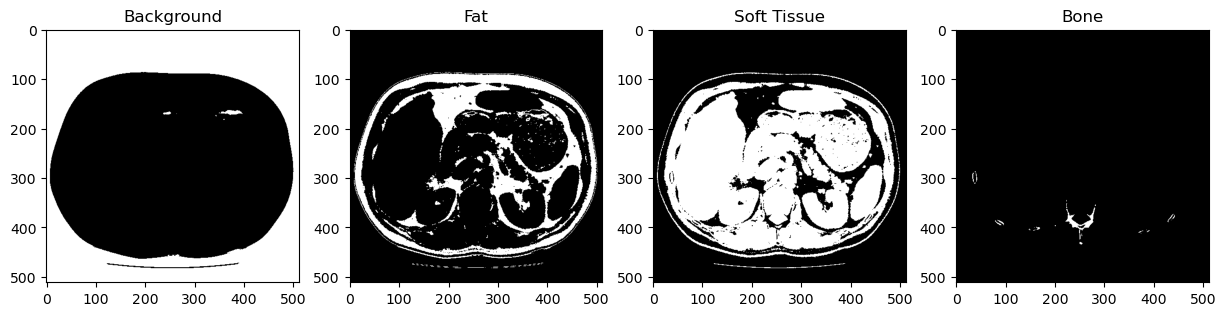

In [37]:
# Exercise 7
# compute mean of soft tissue class 
soft_tissue_values = np.append(kidney_values, spleen_values)
soft_tissue_values = np.append(soft_tissue_values, liver_values)
(mu_soft, std_soft) = norm.fit(soft_tissue_values)

# compute thresholds 
t_background = -200
t_fat_soft = (mu_fat + mu_soft) / 2.0
t_soft_bone = (mu_soft + mu_bone) / 2.0 
print("t_fat_soft",t_fat_soft)
print("t_soft_bone", t_soft_bone)

# compute bimary images 
background_img = img <= t_background 
fat_img = (img > t_background) & (img <= t_fat_soft)
soft_img = (img > t_fat_soft) & (img <= t_soft_bone)
bone_img = img > t_soft_bone 

fig, ax = plt.subplots(1, 4, figsize = (15, 5))
ax[0].imshow(background_img, cmap = "gray")
ax[0].set_title("Background")
ax[1].imshow(fat_img, cmap = "gray")
ax[1].set_title("Fat")
ax[2].imshow(soft_img, cmap = "gray")
ax[2].set_title("Soft Tissue")
ax[3].imshow(bone_img, cmap = "gray")
ax[3].set_title("Bone")
plt.show()

### Exercise 8 
Create class images: fat_img, soft_img and bone_img representing the fat, soft tissue and bone found in the image.

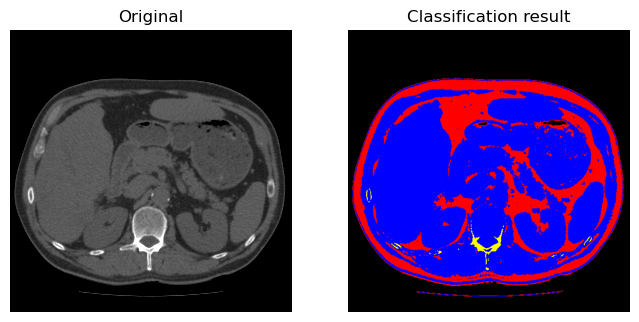

In [35]:
label_img = fat_img + 2 * soft_img + 3 * bone_img
image_label_overlay = label2rgb(label_img)
show_comparison(img, image_label_overlay, 'Classification result')

### Exercise 9 
Visualize your classification result and compare it to the anatomical image in the start of the exercise. Does your results look plausible?

Answer: Also done in the above question

In the parametric classifier, the standard deviation of the training pixel values is also used when determinin the class ranges. In the following, we are also trying to classify background, fat, soft tissue and bone.

We start by finding the class ranges by manually inspecting the fitted Gaussians from each class.

As in the last exercise, we can still se the background-fat threshold to be -200.

### Exercise 9: 
Plot the fitted Gaussians of the training values and manually find the intersection between the curves.

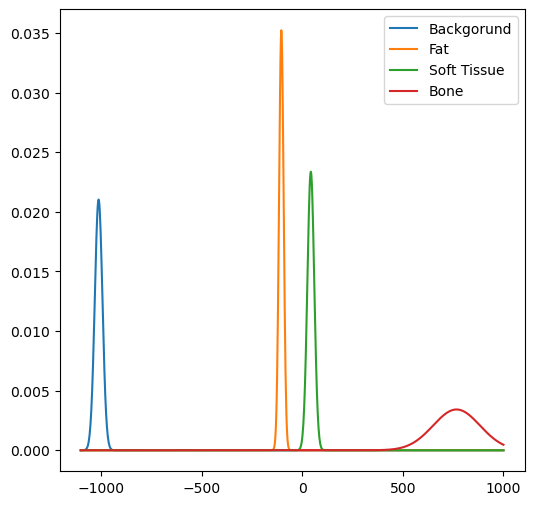

In [39]:
# Exercise 9 
means = np.array([mu_background, mu_fat, mu_soft, mu_bone])
stds = np.array([std_background, std_fat, std_soft, std_bone])
titles = np.array(["Backgorund", "Fat", "Soft Tissue", "Bone"])
x = np.linspace(-1100, 1000, 1000)
plt.figure(figsize = (6, 6))
for i in range(4): 
    plt.plot(x, norm.pdf(x, means[i], stds[i]), label = titles[i])
plt.legend()
plt.show()
# it looks similar to the histogram of the original histogram

### Exercise 10: 
Use the same technique as in exercise 7, 8 and 9 to visualize your classification results. Did it change compared to the minimum distance classifier?

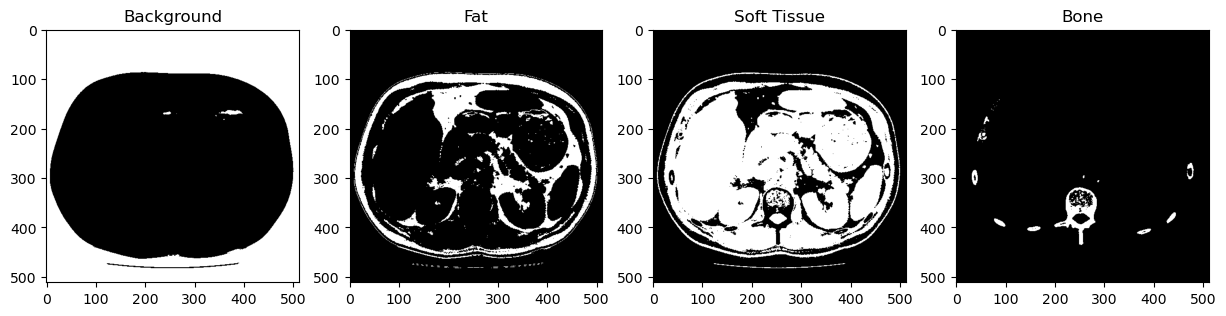

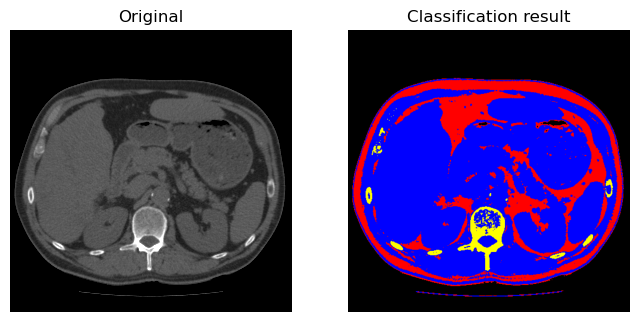

In [43]:
#for test_value in range(-50, -30):
#    if norm.pdf(test_value, mu_fat, std_fat) > norm.pdf(test_value, mu_soft, std_soft):
#        print(f"For value {test_value} the class is fat")
#    else:
#        print(f"For value {test_value} the class is soft tissue")
        
#for test_value in range(0,500):
#    if norm.pdf(test_value, mu_soft, std_soft) > norm.pdf(test_value, mu_bone, std_bone):
#        print(f"For value {test_value} the class is soft tissue")
#    else:
#        print(f"For value {test_value} the class is bone")
        
t_background = -200
t_fat_soft = -45 
t_soft_bone = 141

# compute bimary images 
background_img = img <= t_background 
fat_img = (img > t_background) & (img <= t_fat_soft)
soft_img = (img > t_fat_soft) & (img <= t_soft_bone)
bone_img = img > t_soft_bone 

fig, ax = plt.subplots(1, 4, figsize = (15, 5))
ax[0].imshow(background_img, cmap = "gray")
ax[0].set_title("Background")
ax[1].imshow(fat_img, cmap = "gray")
ax[1].set_title("Fat")
ax[2].imshow(soft_img, cmap = "gray")
ax[2].set_title("Soft Tissue")
ax[3].imshow(bone_img, cmap = "gray")
ax[3].set_title("Bone")
plt.show()

label_img = fat_img + 2 * soft_img + 3 * bone_img
image_label_overlay = label2rgb(label_img)
show_comparison(img, image_label_overlay, 'Classification result')

## Object segmentation - The spleen finder
The goal of this part of the exercise, is to create a program that can automatically segment the spleen in CT images.

We start by using the Training.dcm image and the expert provided annotations.

### Exercise 11: 
Inspect the values of the spleen as in exercise 3 and select a lower and upper threshold to create a spleen class range.

t_1: 19.48611022968417 t_2 79.47442788690776


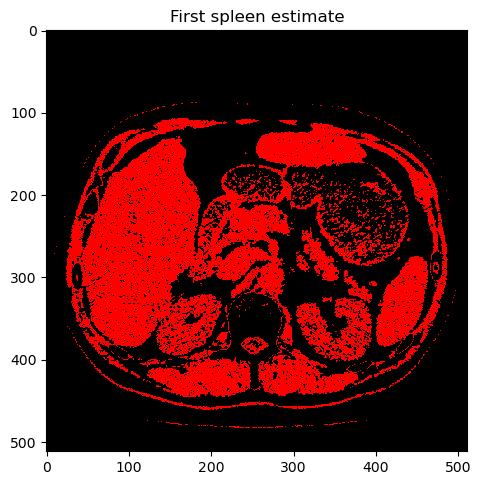

In [47]:
t_1 = mu_spleen - 2*std_spleen
t_2 = mu_spleen + 2*std_spleen
print("t_1:", t_1, "t_2", t_2)
spleen_estimate = (img > t_1) & (img < t_2)
spleen_label_colour = color.label2rgb(spleen_estimate)
io.imshow(spleen_label_colour)
plt.title("First spleen estimate")
io.show()

### Exercise 12: 
Use the above morphological operations to seperate the spleen from other organs and close holes. Change the values where there are question marks to change the size of the used structuring elements and use the methods from BLOB analysis to compute BLOB features for every seperated BLOB in the image.

In [50]:
footprint = disk(2)
closed = binary_closing(spleen_estimate, footprint)

footprint = disk(4)
opened = binary_opening(closed, footprint)

label_img = measure.label(opened)

### Exercise 13: 
Inspect the labeled image and validate the success of separating the spleen from the other objects. If it is connected (have the same color) to another organ, you should experiment with the kernel sizes in the morphological operations.

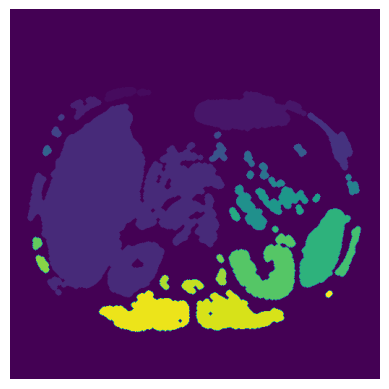

In [51]:
plt.imshow(label_img)
plt.axis("off")
plt.show()

### Exercise 14 
Extend the method above to include several BLOB features. For example area and perimeter. Find the combination of features and feature value limits that will result in only the spleen remaining.

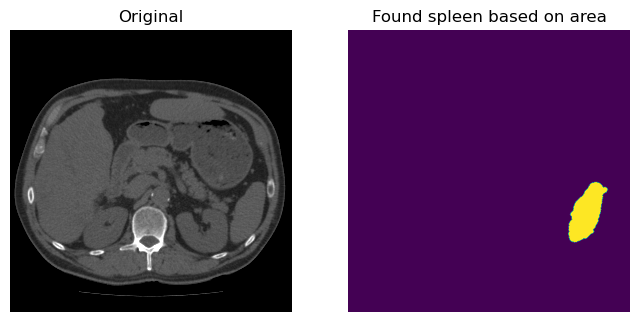

In [52]:
min_area = 2000
max_area = 10000 
min_ecc = 0.90
max_perimeter = 350 

# Create a copy of the label_img
label_img_filter = label_img.copy()
region_props = measure.regionprops(label_img)
for region in region_props:
    # Find the areas that do not fit our criteria
    if region.area > max_area or region.area < min_area or region.eccentricity < min_ecc or region.perimeter > max_perimeter:
        # set the pixels in the invalid areas to background
        for cords in region.coords:
            label_img_filter[cords[0], cords[1]] = 0
# Create binary image from the filtered label image
i_area = label_img_filter > 0
show_comparison(img, i_area, 'Found spleen based on area, perimeter, and ecc')

### Exercise 15: 
Create a function spleen_finder(img) that takes as input a CT image and returns a binary image, where the pixels with value 1 represent the spleen and the pixels with value 0 everything else.

In [55]:
def spleen_finder(ct_image, max_area = 10000, min_area = 1000, min_ecc = 0.9, max_perimeter = 350, min_perimeter = 250): 
    # thresholding 
    t_1, t_2 = 20, 80
    spleen_estimate = (ct_image > t_1) & (ct_image < t_2)
    
    #  morphological operations 
    fp1, fp2 = disk(2), disk(4)
    closed = binary_closing(spleen_estimate, fp1)
    opened = binary_opening(closed, fp2)

    # image to label
    label_img = measure.label(opened)
    label_img_filter = label_img.copy()

    region_props = measure.regionprops(label_img)
    for region in region_props:
        # Find the areas that do not fit our criteria
        if region.area > max_area or region.area < min_area or region.eccentricity < min_ecc or region.perimeter > max_perimeter or region.perimeter < min_perimeter:
            # set the pixels in the invalid areas to background
            for cords in region.coords:
                label_img_filter[cords[0], cords[1]] = 0
    # Create binary image from the filtered label image
    return label_img_filter > 0

### Exercise 16 
Test your function on the images called Validation1.dcm, Validation2.dcm and Validation3.dcm. Do you succeed in finding the spleen in all the validation images?

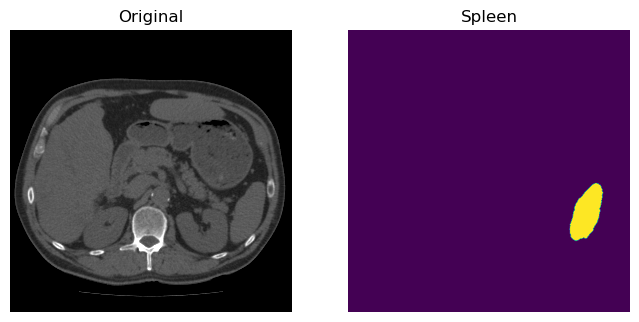

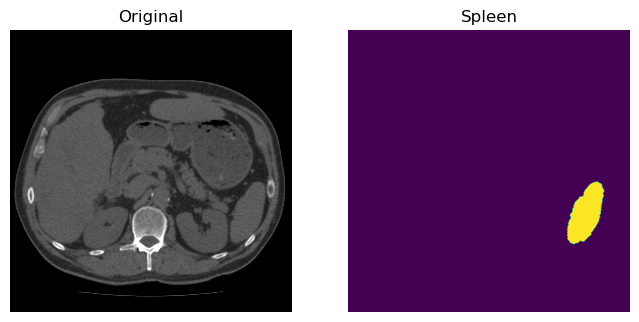

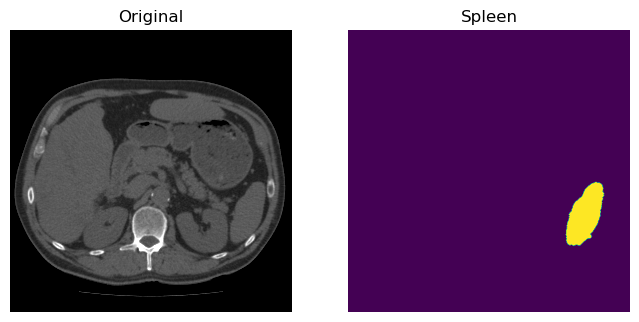

In [56]:
val1, val2, val3 = io.imread("data/Validation1.dcm"), io.imread("data/Validation2.dcm"), io.imread("data/Validation3.dcm")
show_comparison(img, spleen_finder(val1), 'Spleen')
show_comparison(img, spleen_finder(val2), 'Spleen')
show_comparison(img, spleen_finder(val3), 'Spleen')

### Exercise 17 
Compute the DICE score for your found spleen segmentations compared to the ground truth segmentations for the three validation images. How high DICE scores do you achieve?

In [73]:
validation_set = ['Validation1_spleen.png','Validation2_spleen.png','Validation3_spleen.png']
predicted = [spleen_finder(val1),spleen_finder(val2),spleen_finder(val3)]
#gt = 

for i in range(len(validation_set)):
    ground_truth_img = io.imread(in_dir + validation_set[i])
    gt_bin = ground_truth_img > 0
    dice_score = 1 - distance.dice(predicted[i].ravel(), gt_bin.ravel())
    print(f"DICE score of {validation_set[i]} {dice_score}")
    
#TA's solution 
# Exercise 17
# Get predictions 
pred1 = spleen_finder(val1)
pred2 = spleen_finder(val2)
pred3 = spleen_finder(val3)

# get ground thruths 
gt_1 = (io.imread(in_dir + 'Validation1_spleen.png') > 0)
gt_2 = (io.imread(in_dir + 'Validation2_spleen.png') > 0)
gt_3 = (io.imread(in_dir + 'Validation3_spleen.png') > 0)

# get dice scores 
score1 = 1 - distance.dice(pred1.ravel(), gt_1.ravel())
score2 = 1 - distance.dice(pred2.ravel(), gt_3.ravel())
score3 = 1 - distance.dice(pred3.ravel(), gt_3.ravel())

print(f"Score 1 = {score1}, Score 2 = {score2}, Score 3 = {score3}")

DICE score of Validation1_spleen.png 0.9558359621451105
DICE score of Validation2_spleen.png 0.9620925717788904
DICE score of Validation3_spleen.png 0.9715459078908771
Score 1 = 0.9558359621451105, Score 2 = 0.9471671530643051, Score 3 = 0.9715459078908771


## Testing on an independent test set
Overfitting occurs when an algorithm has been developed on a training set and has become so specific to that set of data, that it works badly on other similar data. To avoid this, it is necessary to test an algorithm on an independent test set. We have provided three test images Test1.dcm, Test2.dcm and Test3.dcm with ground truth spleen annotations.

### Exercise 18: 
Use your spleen finder program to find the spleen on the three test images and compute the DICE score. What is the result of your independent test?

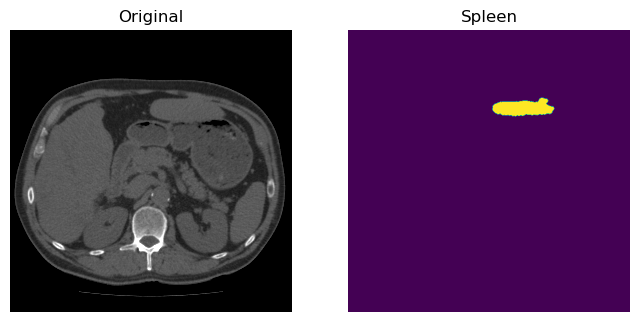

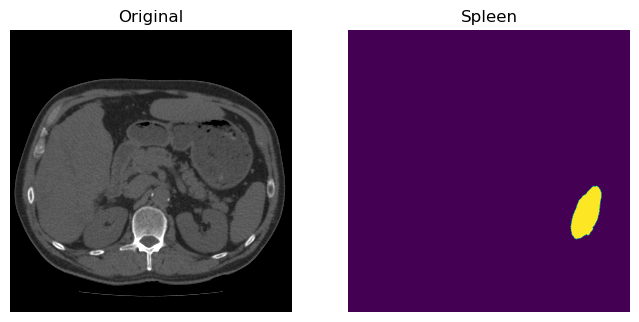

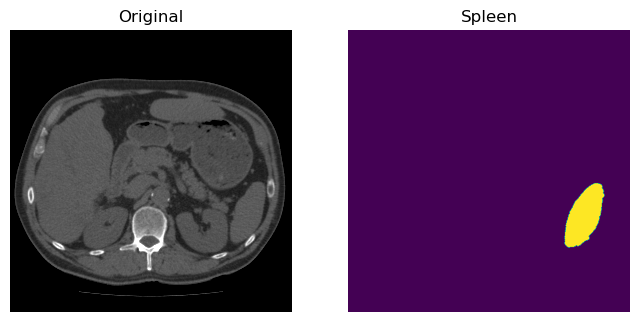

Score 1 = 0.0, Score 2 = 0.779185520361991, Score 3 = 0.967035025285634


In [74]:
test1, test2, test3 = io.imread("data/Test1.dcm"), io.imread("data/Test2.dcm"), io.imread("data/Test3.dcm")
show_comparison(img, spleen_finder(test1), 'Spleen')
show_comparison(img, spleen_finder(test2), 'Spleen')
show_comparison(img, spleen_finder(test3), 'Spleen')

pred1 = spleen_finder(test1)
pred2 = spleen_finder(test2)
pred3 = spleen_finder(test3)

# get ground thruths 
gt_1 = (io.imread(in_dir + 'Test1_spleen.png') > 0)
gt_2 = (io.imread(in_dir + 'Test2_spleen.png') > 0)
gt_3 = (io.imread(in_dir + 'Test3_spleen.png') > 0)

# get dice scores 
score1 = 1 - distance.dice(pred1.ravel(), gt_1.ravel())
score2 = 1 - distance.dice(pred2.ravel(), gt_3.ravel())
score3 = 1 - distance.dice(pred3.ravel(), gt_3.ravel())

print(f"Score 1 = {score1}, Score 2 = {score2}, Score 3 = {score3}")